In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install -qqq ftfy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

## for opening, manipulating, and saving many different image file f
from PIL import Image

import random 

## for plotting
import matplotlib.pyplot as plt

## for processing
import nltk
nltk.download('omw-1.4')
import re
import ftfy
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

#for expanding contracted words
import sys  
!{sys.executable} -m pip install contractions
import contractions

## WordCloud - Python linrary for creating image wordclouds
from wordcloud import WordCloud
from nltk import pos_tag ## For Parts of Speech tagging

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 16.2 MB/s eta 0:00:00


SELECTING DATASETS

In [3]:
ds_all_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/depression_detection.csv")
ds_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Virahonda.csv")
ds_test_kom = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Suicide_Detection_komati.csv")

In [4]:
ds_train_dep = ds_all_train[ds_all_train['label']==1][0:6000]

In [5]:
ds_train_notdep = ds_all_train[ds_all_train['label']==0][0:6000]

In [6]:
ds_all = ds_train_dep.append(ds_train_notdep)

In [7]:
ds_all

,text,label
0,Open discussion. Between the Transfer Portal a...,1
1,Plenty of things are changing in my life and t...,1
2,I feel a little hopeless. Anyone else? #hopele...,1
3,"Which is more healthy? Hope, or hopelessness? ...",1
4,So someone tell me how do I get over #HOPELESS...,1
...,...,...
24185,.. and hit unfollow before I can check their t...,0
24186,.. and its back to work.,0
24187,.-. Getting into coding the RC DB,0
24188,.. Im at liftime fitness just laying here enjo...,0


In [8]:
print(ds_test_kom.head())

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [9]:
ds_test_kom=ds_test_kom.loc[ds_test_kom['class'] == 'suicide']
print(ds_test_kom.head())
ds_test_kom=ds_test_kom.sample(n = 50000,replace = False)
ds_test_kom.reset_index(inplace=True)

   Unnamed: 0                                               text    class
0           2  Ex Wife Threatening SuicideRecently I left my ...  suicide
3           8          i need helpjust help me im crying so hard  suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...  suicide
5          11  Honetly idkI dont know what im even doing here...  suicide
6          12  [Trigger warning] Excuse for self inflicted bu...  suicide


In [10]:
print("Margarida: ",ds_all.shape)
print("virahonda: ",ds_test.shape)
print("komati: ",ds_test_kom.shape)

Margarida:  (12000, 2)
virahonda:  (7145, 1)
komati:  (50000, 4)


In [11]:
print(ds_all.dtypes.to_frame().rename(columns={0:'data_type'}))

      data_type
text     object
label     int64


In [12]:
#ds_all.rename(columns = {'text':'message'}, inplace = True)

REMOVING UNWANTED COLOUMNS FROM DATASETS

In [13]:
# # required only for Margarida dataset
# ds_all.drop(columns=['Unnamed: 0'], inplace=True)
ds_test['label'] = 1

In [14]:
#  old name - text, new - message
print(ds_all.isnull().sum().to_frame().rename(columns={0:'Null values'}))

       Null values
text             0
label            0


In [15]:
ds_test.rename(columns = {'Comments Text':'message'}, inplace = True)
print(ds_test.isnull().sum().to_frame().rename(columns={0:'Null values'}))

         Null values
message            0
label              0


In [16]:
ds_test_kom.drop(columns=['Unnamed: 0','class','index'], inplace=True)
ds_test_kom.rename(columns = {'text':'message'}, inplace = True)
ds_test_kom['label'] = 1
print(ds_test_kom.isnull().sum().to_frame().rename(columns={0:'Null values'}))

         Null values
message            0
label              0


DATASET NOISE CLEANING (PRE-PROCESSING)

In [17]:
def expandContracted(sentence):
  expanded_words = []   
  for word in sentence.split():
    # using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word))  
  res = ' '.join(expanded_words)
  return res

In [18]:
# LEMMATIZATION WITH POS TAG
# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
	if nltk_tag.startswith('J'):
		return wordnet.ADJ
	elif nltk_tag.startswith('V'):
		return wordnet.VERB
	elif nltk_tag.startswith('N'):
		return wordnet.NOUN
	elif nltk_tag.startswith('R'):
		return wordnet.ADV
	else:		
		return None

def lemmatize_func(text):
  lemmatizer = WordNetLemmatizer()
  # tokenize the sentence and find the POS tag for each token
  pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))

  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
    if tag is None:
      lemmatized_sentence.append(word)
    else:
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  lemmatized_sentence = " ".join(lemmatized_sentence)

  return lemmatized_sentence

In [19]:
# PRE-PROCESSING FUNCTION
def cleaning_process(input_tweets, input_labels):
  cleaned_tweets = []
  cleaned_labels = []
  for (a_tweet, a_label) in zip(input_tweets, input_labels):

    #convert to lowercase
    a_tweet = a_tweet.lower()
    
    # if url links then don't append to avoid news articles
    # also check tweet length, save those > 5 
    if re.match("(\w+:\/\/\S+)", a_tweet) == None and len(a_tweet) > 5:
      #remove @mention
      a_tweet = re.sub(r"(?:\@|https?\://)\S+", "", a_tweet)

      #remove punctuation
      a_tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", a_tweet).split())

      #remove hashtag, @mention, HTML tags and image URLs
      a_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<.>)|(pic\.twitter\.com\/.*)", " ", a_tweet).split())
      
      #remove numbers
      a_tweet = re.sub(r'\d+', '', a_tweet)

      #remove urls
      a_tweet = re.sub(r'https?://\S+|www\.\S+', '', a_tweet)

      #fix weirdly encoded texts (Unicode correction)
      a_tweet = ftfy.fix_text(a_tweet)

      #stop words
      stop_words = set(stopwords.words('english'))
      word_tokens = nltk.word_tokenize(a_tweet)
      a_tweet = [word for word in word_tokens if not word in stop_words]
      a_tweet = ' '.join(a_tweet) # join words with a space in between them

      #expand contraction
      a_tweet = expandContracted(a_tweet)

      #lemmatization
      a_tweet = lemmatize_func(a_tweet)

      #removing depression and diagnosis
      a_tweet = re.sub("depression",'', a_tweet)
      a_tweet = re.sub("diagnose", '', a_tweet)

      cleaned_tweets.append(a_tweet)
      cleaned_labels.append(a_label)
  return (cleaned_tweets, cleaned_labels)

CLEANING OF Margarida DATASET

In [20]:
ds_text_all_arr = [x for x in ds_all['text']]
ds_label_all_arr = [x for x in ds_all['label']]
(cleaned_ds_text_all_arr, cleaned_ds_labels_all_arr) = cleaning_process(ds_text_all_arr, ds_label_all_arr)

CLEANING OF VIRAHONDA DATASET

In [21]:
ds_text_test_arr = [x for x in ds_test['message']]
ds_label_test_arr = [x for x in ds_test['label']]
(cleaned_ds_text_test_arr, cleaned_ds_labels_test_arr) = cleaning_process(ds_text_test_arr, ds_label_test_arr)

CLEANING OF KOMATI DATASET

In [22]:
ds_text_test_kom_arr = [x for x in ds_test_kom['message']]
ds_label_test_kom_arr = [x for x in ds_test_kom['label']]
(cleaned_ds_text_test_kom_arr, cleaned_ds_labels_test_kom_arr) = cleaning_process(ds_text_test_kom_arr, ds_label_test_kom_arr)

In [23]:
print(ds_text_all_arr[:10])

['Open discussion. Between the Transfer Portal and the NIL, will the @NCAA become obsolete as an organization and governing body? @zlancaster91 @RAllenGoPokes #Hopelessness #GoPokes #LoyalandTrue', "Plenty of things are changing in my life and the lives of those around me. There is one thing that doesn't change, my #hopelessness.", 'I feel a little hopeless. Anyone else? #hopelessness', 'Which is more healthy? Hope, or hopelessness? #hope #Hopelessness #Mentalhealth', "So someone tell me how do I get over #HOPELESSNESS? \nI live in a world of #poverty surrounded by #PoorPeople.\nPeople help us that are not much better off than we are.\nIf not for my son's inability to care for himself I would likely give into the Hopelessness &amp; darkness.", 'No parent deserves to experience the Indian legal system. #hopelessness', 'Being in a #union also looks a lot like being #alone.\n\nIt can feel like there’s no worse place to be sometimes.\n\n#hopelessness #unions #workersrights', 'I am so glad 

In [24]:
print(cleaned_ds_text_all_arr[:10])

['open discussion transfer portal nil become obsolete organization govern body hopelessness gopokes loyalandtrue', 'plenty thing change life life around one thing change hopelessness', 'feel little hopeless anyone else hopelessness', 'healthy hope hopelessness hope hopelessness mentalhealth', 'someone tell get hopelessness live world poverty surround poorpeople people help us much good son inability care would likely give hopelessness amp darkness', 'parent deserve experience indian legal system hopelessness', 'union also look lot like alone feel like bad place sometimes hopelessness union workersrights', 'glad tackle huge healthcare professional shortage face sadden really live post pandemic world burnout hopelessness stress palpable every level department system', 'know someone depressed please resolve never ask  straightforward response bad situation  like weather try understand blackness lethargy hopelessness loneliness go', 'grateful heart seegod find every situation despair hopel

WORD CLOUDS

In [25]:
ds_depressed = []
ds_notdepressed = []

for (text, label) in zip(cleaned_ds_text_all_arr, cleaned_ds_labels_all_arr):
  if label == 1:
    ds_depressed.append(text)
  else:
    ds_notdepressed.append(text)

In [26]:
str_depressed = ' '.join(ds_depressed)
str_notdepressed = ' '.join(ds_notdepressed)
str_vir = ' '.join(cleaned_ds_text_test_arr)
str_kom = ' '.join(cleaned_ds_text_test_kom_arr)

In [27]:
image = np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Dataset/logo.jpeg'))

fig = plt.figure() # Instantiate the figure object
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

<Figure size 1400x1800 with 0 Axes>

In [28]:
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

WORD CLOUD FOR Margarida DATASET DEPRESSED

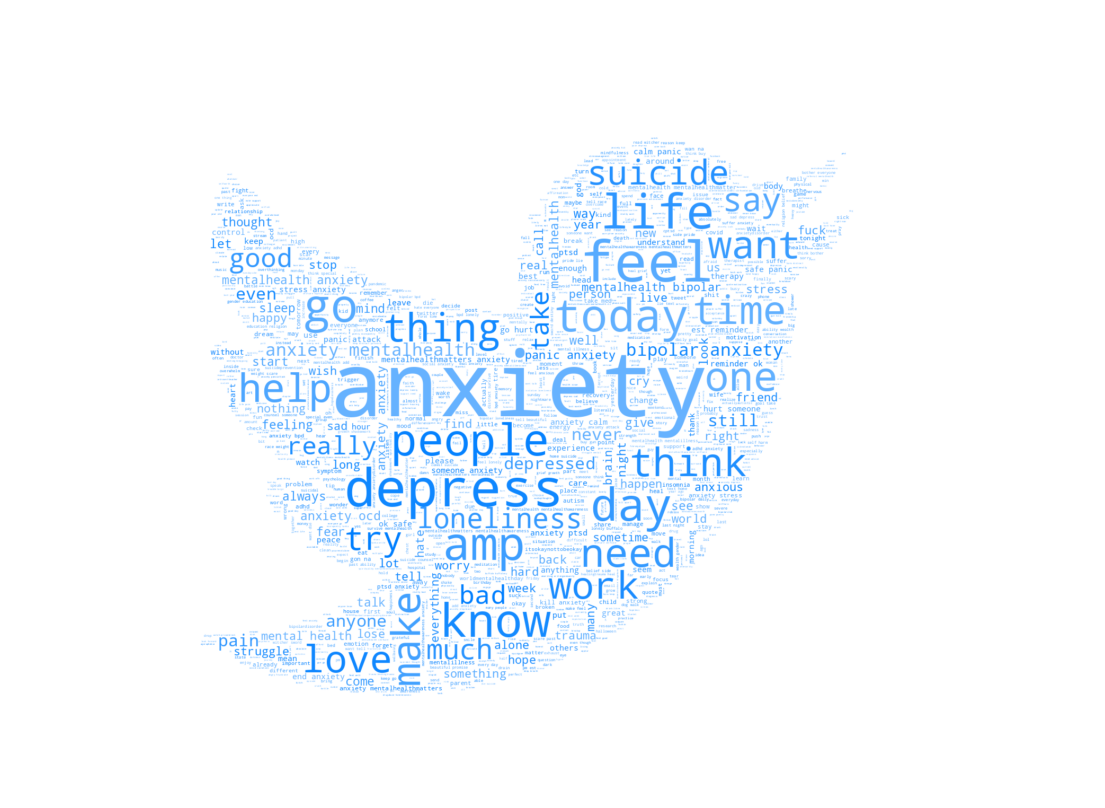

In [29]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_depressed)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR Margarida DATASET NOT DEPRESSED

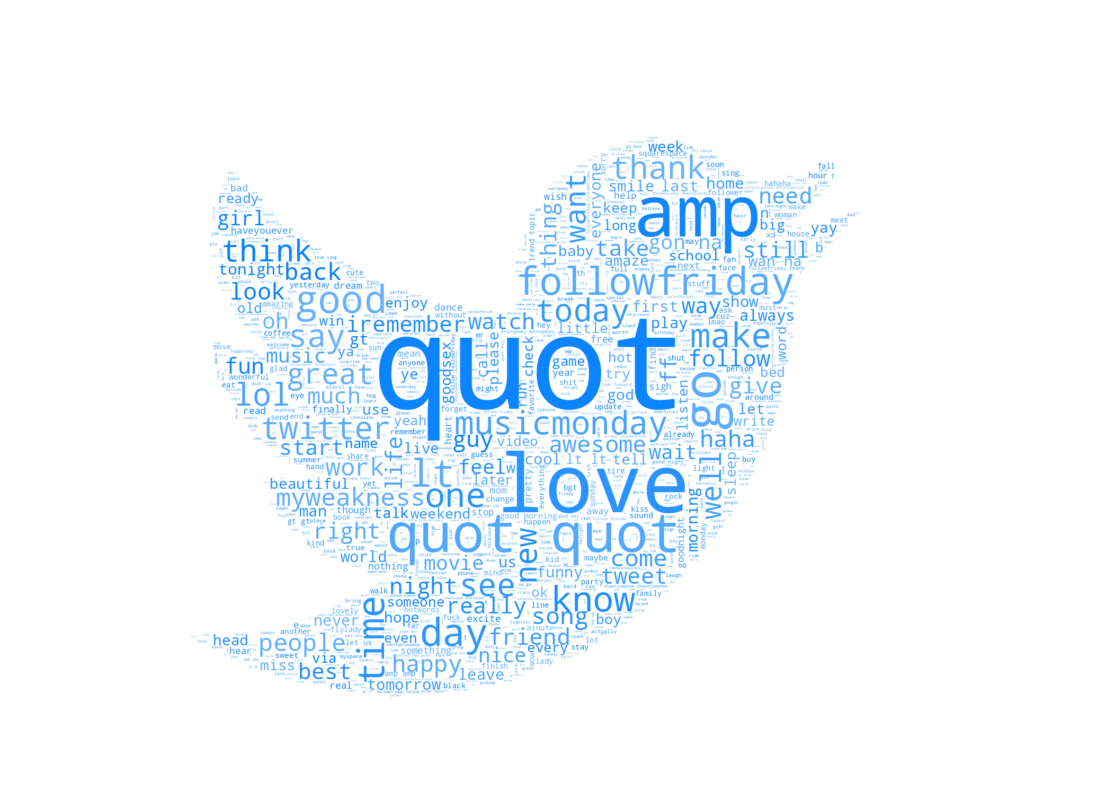

In [30]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_notdepressed)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR VIRAHONDA DATASET

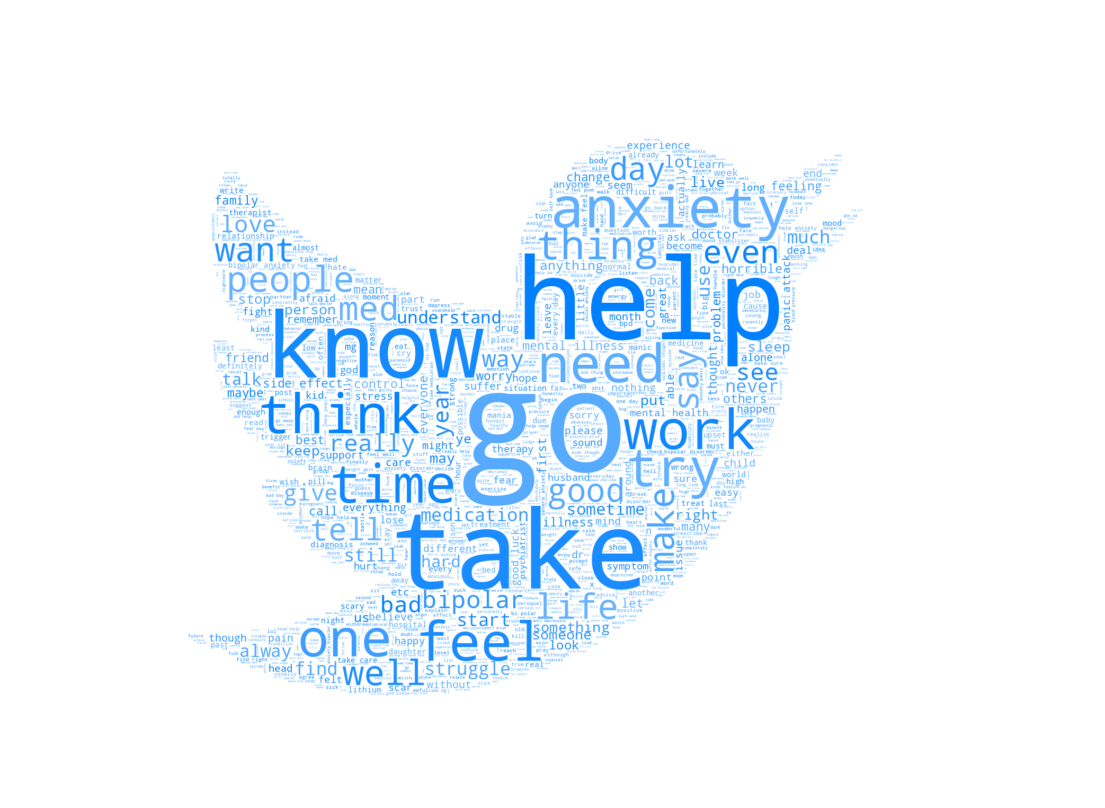

In [31]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_vir)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

WORD CLOUD FOR KOMATI DATASET

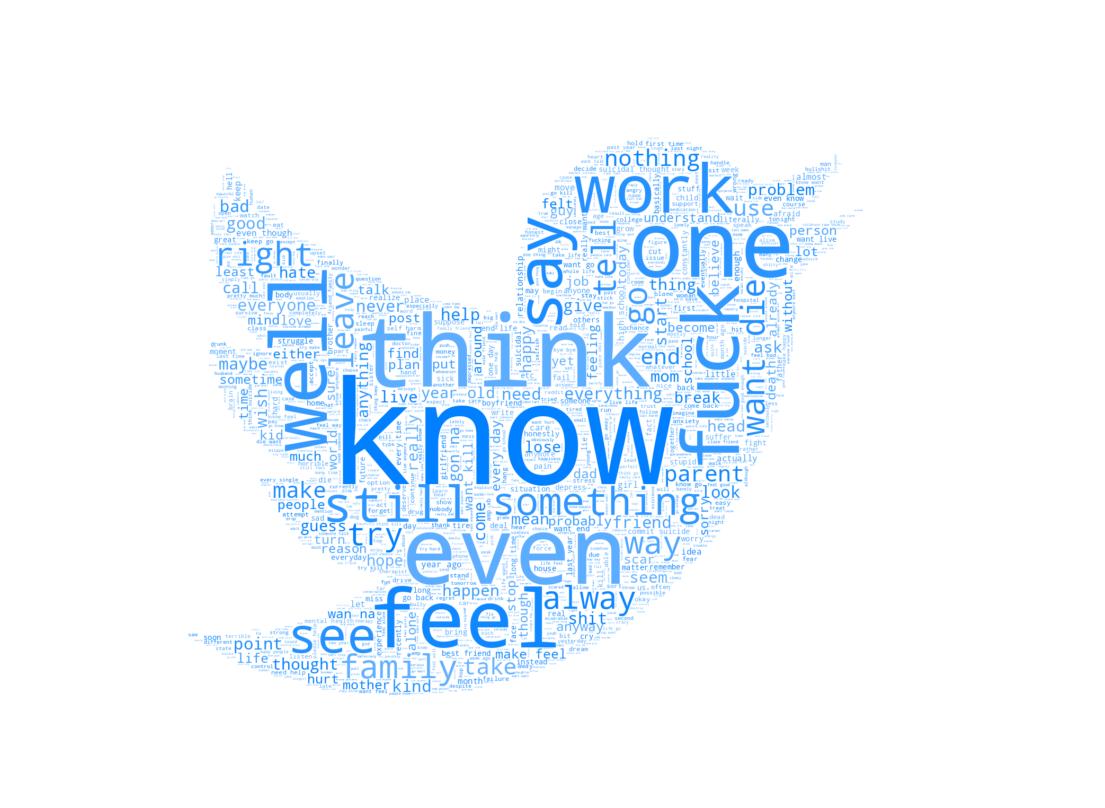

In [32]:
twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

## generate the word cloud
twitter_wc.generate(str_kom)

## display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(twitter_wc.recolor(color_func=blue_color_func, random_state=3),interpolation="bilinear")
plt.axis('off')
plt.show()

BAG OF WORDS

In [33]:
from collections import Counter
from itertools import chain
from nltk.util import ngrams
from nltk.util import bigrams

def bow_for_line(corpus, top_words):
  bag_of_words = []
  for doc in corpus:
    unigram_words = doc
    bigram_words = list(bigrams(doc))
    trigram_words = list(ngrams(doc, 3))
    
    word_counts = Counter(doc)
    bigram_word_counts = Counter(bigram_words)
    trigram_word_counts = Counter(trigram_words)

    word_count=dict(word_counts)
    word_count.update(dict(bigram_word_counts))
    word_count.update(dict(trigram_word_counts))

    dict_words = dict(word_count)
    line_words = Counter(dict_words)

    row = [line_words[word] if word in line_words else 0 for word in top_words]
    bag_of_words.append(row)

  return bag_of_words

def bow(data_train):
  # Preprocess and tokenize the corpus
  corpus = [nltk.word_tokenize(doc.lower()) for doc in data_train]

  # Calculate the frequency of each word in the corpus
  word_counts = Counter(chain.from_iterable(corpus))

  bigram_words = []
  for doc in corpus:
    words = list(bigrams(doc))
    bigram_words.append(words)

  # Calculate the frequency of each bi and trigram words in the corpus
  bigram_word_counts = Counter(chain.from_iterable(bigram_words))

  trigram_words = []
  for doc in corpus:
    words = list(ngrams(doc, 3))
    trigram_words.append(words)

  trigram_word_counts = Counter(chain.from_iterable(trigram_words))

  word_count=dict(word_counts)
  word_count.update(dict(bigram_word_counts))
  word_count.update(dict(trigram_word_counts))

  word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
  dict_words = dict(word_count)
  final_words = Counter(dict_words)

  # # Select the top k most frequent words as columns
  top_words = [word for word, count in final_words.most_common(5000)]

  # # # Create the bag of words matrix
  bag_of_words = bow_for_line(corpus, top_words)
  
  return bag_of_words, top_words

BOW for Margarida

In [34]:
bag_of_words, top_words = bow(cleaned_ds_text_all_arr)

print(len(bag_of_words[0]))
print(len(top_words))

5000
5000


In [35]:
column_words = []
for word in top_words:
  if isinstance(word, tuple):
    column_words.append(" ".join(word))
  else:
    column_words.append(word)

In [36]:
df = pd.DataFrame (bag_of_words, columns = column_words)
df.head()

,anxiety,quot,get,go,mentalhealth,amp,like,feel,day,love,...,well do,may feel,matter much,people get,life hard,go die,take year,like depressed,go around,come get
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X = df
y = cleaned_ds_labels_all_arr
print(len(X), len(y))

12000 12000


BOW for VIRAHONDA

In [38]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in cleaned_ds_text_test_arr]

bag_of_words_test = bow_for_line(corpus, top_words)

In [39]:
test_df = pd.DataFrame (bag_of_words_test, columns = column_words)

In [40]:
test_df.head()

,anxiety,quot,get,go,mentalhealth,amp,like,feel,day,love,...,well do,may feel,matter much,people get,life hard,go die,take year,like depressed,go around,come get
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,3,0,0,0,2,2,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,4,0,0,2,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
X_vir = test_df
y_vir = cleaned_ds_labels_test_arr
len(X_vir), len(y_vir)

(7139, 7139)

BOW for KOMATI

In [42]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in cleaned_ds_text_test_kom_arr]

bag_of_words_test_kom = bow_for_line(corpus, top_words)

In [43]:
test_df_kom = pd.DataFrame (bag_of_words_test_kom, columns = column_words)

In [44]:
test_df_kom.head()

,anxiety,quot,get,go,mentalhealth,amp,like,feel,day,love,...,well do,may feel,matter much,people get,life hard,go die,take year,like depressed,go around,come get
0,0,0,5,3,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,4,12,0,0,1,1,3,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,4,0,0,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,2,0,0,4,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X_kom = test_df_kom
y_kom = cleaned_ds_labels_test_kom_arr
len(X_kom), len(y_kom)

(49993, 49993)

BOW for Margarida DEPRESSED

In [46]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in ds_depressed]

bag_of_words_test_dep = bow_for_line(corpus, top_words)

In [47]:
test_df_dep = pd.DataFrame (bag_of_words_test_dep, columns = column_words)

In [48]:
test_df_dep.head()

,anxiety,quot,get,go,mentalhealth,amp,like,feel,day,love,...,well do,may feel,matter much,people get,life hard,go die,take year,like depressed,go around,come get
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X_dep = test_df_dep
y_dep=[]
for x in cleaned_ds_labels_all_arr:
  if x==1:
    y_dep.append(x)
len(X_dep), len(y_dep)

(6000, 6000)

BOW for Margarida NOT DEPRESSED

In [50]:
corpus = [nltk.word_tokenize(doc.lower()) for doc in ds_notdepressed]

bag_of_words_test_ndep = bow_for_line(corpus, top_words)

In [51]:
test_df_ndep = pd.DataFrame (bag_of_words_test_ndep, columns = column_words)

In [52]:
test_df_ndep.head()

,anxiety,quot,get,go,mentalhealth,amp,like,feel,day,love,...,well do,may feel,matter much,people get,life hard,go die,take year,like depressed,go around,come get
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
X_ndep = test_df_ndep
y_ndep=[]
for x in cleaned_ds_labels_all_arr:
  if x==0:
    y_ndep.append(x)
len(X_ndep), len(y_ndep)

(6000, 6000)

10 - FOLD CROSS VALIDATION FOR MODELS

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True)
splits=list(kf.split(X,y))
splits_test_vir=list(kf.split(X_vir,y_vir))
splits_test_kom=list(kf.split(X_kom,y_kom))
splits_test_dep=list(kf.split(X_dep,y_dep))
splits_test_ndep=list(kf.split(X_ndep,y_ndep))

LOGISTIC REGRESSION

In [55]:
LogReg_scores_Margarida = []
LogReg_scores_vir = []
LogReg_scores_kom = []
LogReg_scores_dep = []
LogReg_scores_ndep = []
LogReg_scores = []

f1_scores_Margarida = []
precision_scores_Margarida = []
recall_scores_Margarida = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_Log = LogisticRegression()
  model_Log.fit(X_train, y_train)
  y_pred = model_Log.predict(X_test)
  
  print("Fold - {} completed".format(k))

  #Margarida testing
  LogReg_scores_Margarida.append(model_Log.score(X_test, y_test))
  y_pred_Margarida = model_Log.predict(X_test)
  f1_scores_Margarida.append(f1_score(y_test, y_pred_Margarida, average='macro'))
  precision_scores_Margarida.append(precision_score(y_test, y_pred_Margarida, average='macro'))
  recall_scores_Margarida.append(recall_score(y_test, y_pred_Margarida, average='macro'))

  #Virahonda testing
  LogReg_scores_vir.append(model_Log.score(X_test_vir, y_test_vir))

  #Komati testing
  LogReg_scores_kom.append(model_Log.score(X_test_kom, y_test_kom))

  #Margarida depressed only testing
  LogReg_scores_dep.append(model_Log.score(X_test_dep, y_test_dep))

  #Margarida not depressed only testing
  LogReg_scores_ndep.append(model_Log.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_Margarida)*100 + np.std(LogReg_scores_Margarida)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_vir)*100 + np.std(LogReg_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_kom)*100 + np.std(LogReg_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_dep)*100 + np.std(LogReg_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:')
print('CV accuracy LogReg: %.4f' %(np.mean(LogReg_scores_ndep)*100 + np.std(LogReg_scores_ndep)*100))

LogReg_scores.append(np.mean(LogReg_scores_Margarida)*100 + np.std(LogReg_scores_Margarida)*100)
LogReg_scores.append(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100)
LogReg_scores.append(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100)
LogReg_scores.append(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100)
LogReg_scores.append(np.mean(LogReg_scores_dep)*100 + np.std(LogReg_scores_dep)*100)
LogReg_scores.append(np.mean(LogReg_scores_ndep)*100 + np.std(LogReg_scores_ndep)*100)
LogReg_scores.append(np.mean(LogReg_scores_kom)*100 + np.std(LogReg_scores_kom)*100)
LogReg_scores.append(np.mean(LogReg_scores_vir)*100 + np.std(LogReg_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:
CV accuracy LogReg: 100.0000
CV F1 score: 100.0000
CV Precision: 99.9999
CV Recall: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:
CV accuracy LogReg: 55.5765


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:
CV accuracy LogReg: 75.9447


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:
CV accuracy LogReg: 100.0333


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:
CV accuracy LogReg: 100.0000


LSVM

In [56]:
LSVM_scores_Margarida = []
LSVM_scores_vir = []
LSVM_scores_kom = []
LSVM_scores_dep = []
LSVM_scores_ndep = []
LSVM_scores = []

f1_scores_Margarida = []
precision_scores_Margarida = []
recall_scores_Margarida = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_LSVM = LinearSVC()
  model_LSVM.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Margarida testing
  LSVM_scores_Margarida.append(model_LSVM.score(X_test, y_test))
  y_pred_Margarida = model_LSVM.predict(X_test)
  f1_scores_Margarida.append(f1_score(y_test, y_pred_Margarida, average='macro'))
  precision_scores_Margarida.append(precision_score(y_test, y_pred_Margarida, average='macro'))
  recall_scores_Margarida.append(recall_score(y_test, y_pred_Margarida, average='macro'))

  #Virahonda testing
  LSVM_scores_vir.append(model_LSVM.score(X_test_vir, y_test_vir))

  #Komati testing
  LSVM_scores_kom.append(model_LSVM.score(X_test_kom, y_test_kom))

  #Margarida depressed only testing
  LSVM_scores_dep.append(model_LSVM.score(X_test_dep, y_test_dep))

  #Margarida not depressed only testing
  LSVM_scores_ndep.append(model_LSVM.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_Margarida)*100 + np.std(LSVM_scores_Margarida)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_vir)*100 + np.std(LSVM_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_kom)*100 + np.std(LSVM_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_dep)*100 + np.std(LSVM_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:')
print('CV accuracy LSVM: %.4f' %(np.mean(LSVM_scores_ndep)*100 + np.std(LSVM_scores_ndep)*100))

LSVM_scores.append(np.mean(LSVM_scores_Margarida)*100 + np.std(LSVM_scores_Margarida)*100)
LSVM_scores.append(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100)
LSVM_scores.append(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100)
LSVM_scores.append(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100)
LSVM_scores.append(np.mean(LSVM_scores_dep)*100 + np.std(LSVM_scores_dep)*100)
LSVM_scores.append(np.mean(LSVM_scores_ndep)*100 + np.std(LSVM_scores_ndep)*100)
LSVM_scores.append(np.mean(LSVM_scores_kom)*100 + np.std(LSVM_scores_kom)*100)
LSVM_scores.append(np.mean(LSVM_scores_vir)*100 + np.std(LSVM_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:
CV accuracy LSVM: 100.0000
CV F1 score: 100.0000
CV Precision: 100.0000
CV Recall: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:
CV accuracy LSVM: 40.0726


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:
CV accuracy LSVM: 40.3904


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:
CV accuracy LSVM: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:
CV accuracy LSVM: 100.0000


MLP

In [57]:
MLP_scores_Margarida = []
MLP_scores_vir = []
MLP_scores_kom = []
MLP_scores_dep = []
MLP_scores_ndep = []
MLP_scores = []

f1_scores_Margarida = []
precision_scores_Margarida = []
recall_scores_Margarida = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_MLP = MLPClassifier(hidden_layer_sizes=(100,), max_iter=10)
  model_MLP.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Margarida testing
  MLP_scores_Margarida.append(model_MLP.score(X_test, y_test))
  y_pred_Margarida = model_MLP.predict(X_test)
  f1_scores_Margarida.append(f1_score(y_test, y_pred_Margarida, average='macro'))
  precision_scores_Margarida.append(precision_score(y_test, y_pred_Margarida, average='macro'))
  recall_scores_Margarida.append(recall_score(y_test, y_pred_Margarida, average='macro'))

  #Virahonda testing
  MLP_scores_vir.append(model_MLP.score(X_test_vir, y_test_vir))

  #Komati testing
  MLP_scores_kom.append(model_MLP.score(X_test_kom, y_test_kom))

  #Margarida depressed only testing
  MLP_scores_dep.append(model_MLP.score(X_test_dep, y_test_dep))

  #Margarida not depressed only testing
  MLP_scores_ndep.append(model_MLP.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_Margarida)*100 + np.std(MLP_scores_Margarida)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_vir)*100 + np.std(MLP_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_kom)*100 + np.std(MLP_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_dep)*100 + np.std(MLP_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:')
print('CV accuracy MLP: %.4f' %(np.mean(MLP_scores_ndep)*100 + np.std(MLP_scores_ndep)*100))

MLP_scores.append(np.mean(MLP_scores_Margarida)*100 + np.std(MLP_scores_Margarida)*100)
MLP_scores.append(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100)
MLP_scores.append(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100)
MLP_scores.append(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100)
MLP_scores.append(np.mean(MLP_scores_dep)*100 + np.std(MLP_scores_dep)*100)
MLP_scores.append(np.mean(MLP_scores_ndep)*100 + np.std(MLP_scores_ndep)*100)
MLP_scores.append(np.mean(MLP_scores_kom)*100 + np.std(MLP_scores_kom)*100)
MLP_scores.append(np.mean(MLP_scores_vir)*100 + np.std(MLP_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:
CV accuracy MLP: 99.7000
CV F1 score: 99.7000
CV Precision: 99.7006
CV Recall: 99.7000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:
CV accuracy MLP: 78.6216


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:
CV accuracy MLP: 88.6834


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:
CV accuracy MLP: 100.0106


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:
CV accuracy MLP: 100.0333


DECISION TREE

In [58]:
DT_scores_Margarida = []
DT_scores_vir = []
DT_scores_kom = []
DT_scores_dep = []
DT_scores_ndep = []
DT_scores = []

f1_scores_Margarida = []
precision_scores_Margarida = []
recall_scores_Margarida = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_DT = DecisionTreeClassifier()
  model_DT.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Margarida testing
  DT_scores_Margarida.append(model_DT.score(X_test, y_test))
  y_pred_Margarida = model_DT.predict(X_test)
  f1_scores_Margarida.append(f1_score(y_test, y_pred_Margarida, average='macro'))
  precision_scores_Margarida.append(precision_score(y_test, y_pred_Margarida, average='macro'))
  recall_scores_Margarida.append(recall_score(y_test, y_pred_Margarida, average='macro'))

  #Virahonda testing
  DT_scores_vir.append(model_DT.score(X_test_vir, y_test_vir))

  #Komati testing
  DT_scores_kom.append(model_DT.score(X_test_kom, y_test_kom))

  #Margarida depressed only testing
  DT_scores_dep.append(model_DT.score(X_test_dep, y_test_dep))

  #Margarida not depressed only testing
  DT_scores_ndep.append(model_DT.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_Margarida)*100 + np.std(DT_scores_Margarida)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_vir)*100 + np.std(DT_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_kom)*100 + np.std(DT_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_dep)*100 + np.std(DT_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:')
print('CV accuracy DT: %.4f' %(np.mean(DT_scores_ndep)*100 + np.std(DT_scores_ndep)*100))

DT_scores.append(np.mean(DT_scores_Margarida)*100 + np.std(DT_scores_Margarida)*100)
DT_scores.append(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100)
DT_scores.append(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100)
DT_scores.append(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100)
DT_scores.append(np.mean(DT_scores_dep)*100 + np.std(DT_scores_dep)*100)
DT_scores.append(np.mean(DT_scores_ndep)*100 + np.std(DT_scores_ndep)*100)
DT_scores.append(np.mean(DT_scores_kom)*100 + np.std(DT_scores_kom)*100)
DT_scores.append(np.mean(DT_scores_vir)*100 + np.std(DT_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:
CV accuracy DT: 100.0000
CV F1 score: 100.0000
CV Precision: 100.0000
CV Recall: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:
CV accuracy DT: 39.5987


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:
CV accuracy DT: 35.5202


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:
CV accuracy DT: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:
CV accuracy DT: 100.0000


RESULT

In [59]:
LogReg_scores = [round(float(LogReg_scores[i]), 2) for i in range(0, len(LogReg_scores))]
LSVM_scores = [round(float(LSVM_scores[i]), 2) for i in range(0, len(LSVM_scores))]
MLP_scores = [round(float(MLP_scores[i]), 2) for i in range(0, len(MLP_scores))]
DT_scores = [round(float(DT_scores[i]), 2) for i in range(0, len(DT_scores))]

In [60]:
LogReg_scores.insert(0, "LR")
LSVM_scores.insert(0, "LSVM")
MLP_scores.insert(0, "MLP")
DT_scores.insert(0, "DT")

In [61]:
scores = []
scores.append(LogReg_scores)
scores.append(LSVM_scores)
scores.append(MLP_scores)
scores.append(DT_scores)

In [62]:
scores

[['LR', 100.0, 100.0, 100.0, 100.0, 100.03, 100.0, 75.94, 55.58],
 ['LSVM', 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 40.39, 40.07],
 ['MLP', 99.7, 99.7, 99.7, 99.7, 100.01, 100.03, 88.68, 78.62],
 ['DT', 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 35.52, 39.6]]

In [63]:
df = pd.DataFrame(scores, columns=['Classifier', 'Acc', 'Prec', 'Rec', 'F1', 'Dep', 'Non-Dep', 'Kom', 'Vir'])

In [64]:
df

,Classifier,Acc,Prec,Rec,F1,Dep,Non-Dep,Kom,Vir
0,LR,100.0,100.0,100.0,100.0,100.03,100.00,75.94,55.58
1,LSVM,100.0,100.0,100.0,100.0,100.00,100.00,40.39,40.07
2,MLP,99.7,99.7,99.7,99.7,100.01,100.03,88.68,78.62
3,DT,100.0,100.0,100.0,100.0,100.00,100.00,35.52,39.60


GRAPH PLOTTING

In [65]:
w=0.2
x = df['Classifier']
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]

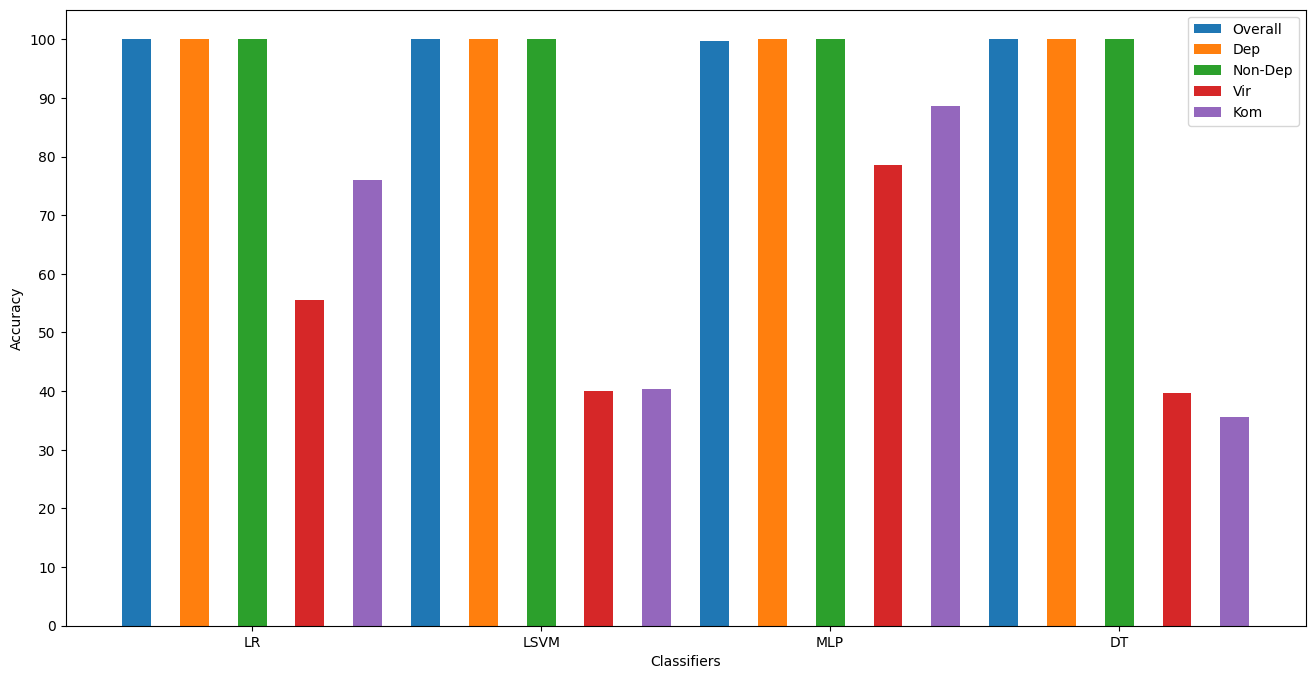

In [66]:
plt.figure(figsize=(16,8))
plt.bar(bar1, df['Acc'], label='Overall', align='edge', width=0.1)
plt.bar(bar2, df['Dep'], align='edge', width=0.1, label='Dep')
plt.bar(bar3, df['Non-Dep'], align='edge', width=0.1, label='Non-Dep')
plt.bar(bar4, df['Vir'], align='edge', width=0.1, label='Vir')
plt.bar(bar5, df['Kom'], align='edge', width=0.1, label='Kom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks(bar1+0.45, x)
plt.yticks(np.arange(0, 101, 10))
plt.legend(loc='upper right')
plt.show()

PLOTTING DECISION TREE

In [67]:
# X_dep = test_df_dep.iloc[:50, :10]
# X_notDep = test_df_ndep.iloc[:50, :10]
# X_tree = X_dep.append(X_notDep, ignore_index=True)
# X_tree.shape

In [68]:
# y_dep = [1 for i in range(0, 50)]
# y_notDep = [0 for i in range(0, 50)]
# y_tree = []
# y_tree.extend(y_dep)
# y_tree.extend(y_notDep)
# len(y_tree)

In [69]:
# X_tree.head()

In [70]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn import tree
# from sklearn import metrics

In [71]:
# X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y_tree, test_size=0.3) # 70% training and 30% test
# model = DecisionTreeClassifier(criterion="gini",max_depth=8)
# model.fit(X_tree_train, y_tree_train)

In [72]:
# fig = plt.figure(figsize=(25,20))
# figPlt = tree.plot_tree(model, feature_names=column_words[:10], class_names=["ndep", "dep"], filled=True)

In [73]:
# y_pred_tree = model.predict(X_tree_test)

In [74]:
# print("Accuracy:",metrics.accuracy_score(y_tree_test, y_pred_tree))

In [75]:
# model1 = DecisionTreeClassifier(criterion="entropy",max_depth=8)
# model1.fit(X_tree_train, y_tree_train)

In [76]:
# fig = plt.figure(figsize=(25,20))
# figPlt = tree.plot_tree(model1, feature_names=column_words[:10], class_names=["ndep", "dep"], filled=True)

In [77]:
# y_pred_tree1 = model1.predict(X_tree_test)

In [78]:
# print("Accuracy:",metrics.accuracy_score(y_tree_test, y_pred_tree1))

ENSEMBLE CLASSIFIERS

Adaptive Boosting

In [79]:
from sklearn.ensemble import AdaBoostClassifier
AB_scores_Margarida = []
AB_scores_vir = []
AB_scores_kom = []
AB_scores_dep = []
AB_scores_ndep = []
AB_scores = []

f1_scores_Margarida = []
precision_scores_Margarida = []
recall_scores_Margarida = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_AB = AdaBoostClassifier()
  model_AB.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Margarida testing
  AB_scores_Margarida.append(model_AB.score(X_test, y_test))
  y_pred_Margarida = model_AB.predict(X_test)
  f1_scores_Margarida.append(f1_score(y_test, y_pred_Margarida, average='macro'))
  precision_scores_Margarida.append(precision_score(y_test, y_pred_Margarida, average='macro'))
  recall_scores_Margarida.append(recall_score(y_test, y_pred_Margarida, average='macro'))

  #Virahonda testing
  AB_scores_vir.append(model_AB.score(X_test_vir, y_test_vir))

  #Komati testing
  AB_scores_kom.append(model_AB.score(X_test_kom, y_test_kom))

  #Margarida depressed only testing
  AB_scores_dep.append(model_AB.score(X_test_dep, y_test_dep))

  #Margarida not depressed only testing
  AB_scores_ndep.append(model_AB.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_Margarida)*100 + np.std(AB_scores_Margarida)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_vir)*100 + np.std(AB_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_kom)*100 + np.std(AB_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_dep)*100 + np.std(AB_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:')
print('CV accuracy AB: %.4f' %(np.mean(AB_scores_ndep)*100 + np.std(AB_scores_ndep)*100))

AB_scores.append(np.mean(AB_scores_Margarida)*100 + np.std(AB_scores_Margarida)*100)
AB_scores.append(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100)
AB_scores.append(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100)
AB_scores.append(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100)
AB_scores.append(np.mean(AB_scores_dep)*100 + np.std(AB_scores_dep)*100)
AB_scores.append(np.mean(AB_scores_ndep)*100 + np.std(AB_scores_ndep)*100)
AB_scores.append(np.mean(AB_scores_kom)*100 + np.std(AB_scores_kom)*100)
AB_scores.append(np.mean(AB_scores_vir)*100 + np.std(AB_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:
CV accuracy AB: 100.0000
CV F1 score: 100.0000
CV Precision: 100.0000
CV Recall: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:
CV accuracy AB: 39.5987


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:
CV accuracy AB: 35.5202


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:
CV accuracy AB: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:
CV accuracy AB: 100.0000


In [80]:
from sklearn.ensemble import BaggingClassifier
Bag_scores_Margarida = []
Bag_scores_vir = []
Bag_scores_kom = []
Bag_scores_dep = []
Bag_scores_ndep = []
Bag_scores = []

f1_scores_Margarida = []
precision_scores_Margarida = []
recall_scores_Margarida = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_Bag = BaggingClassifier()
  model_Bag.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Margarida testing
  Bag_scores_Margarida.append(model_Bag.score(X_test, y_test))
  y_pred_Margarida = model_Bag.predict(X_test)
  f1_scores_Margarida.append(f1_score(y_test, y_pred_Margarida, average='macro'))
  precision_scores_Margarida.append(precision_score(y_test, y_pred_Margarida, average='macro'))
  recall_scores_Margarida.append(recall_score(y_test, y_pred_Margarida, average='macro'))

  #Virahonda testing
  Bag_scores_vir.append(model_Bag.score(X_test_vir, y_test_vir))

  #Komati testing
  Bag_scores_kom.append(model_Bag.score(X_test_kom, y_test_kom))

  #Margarida depressed only testing
  Bag_scores_dep.append(model_Bag.score(X_test_dep, y_test_dep))

  #Margarida not depressed only testing
  Bag_scores_ndep.append(model_Bag.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_Margarida)*100 + np.std(Bag_scores_Margarida)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_vir)*100 + np.std(Bag_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_kom)*100 + np.std(Bag_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_dep)*100 + np.std(Bag_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:')
print('CV accuracy BP: %.4f' %(np.mean(Bag_scores_ndep)*100 + np.std(Bag_scores_ndep)*100))

Bag_scores.append(np.mean(Bag_scores_Margarida)*100 + np.std(Bag_scores_Margarida)*100)
Bag_scores.append(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100)
Bag_scores.append(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100)
Bag_scores.append(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100)
Bag_scores.append(np.mean(Bag_scores_dep)*100 + np.std(Bag_scores_dep)*100)
Bag_scores.append(np.mean(Bag_scores_ndep)*100 + np.std(Bag_scores_ndep)*100)
Bag_scores.append(np.mean(Bag_scores_kom)*100 + np.std(Bag_scores_kom)*100)
Bag_scores.append(np.mean(Bag_scores_vir)*100 + np.std(Bag_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:
CV accuracy BP: 100.0000
CV F1 score: 100.0000
CV Precision: 100.0000
CV Recall: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:
CV accuracy BP: 39.5987


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:
CV accuracy BP: 35.5202


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:
CV accuracy BP: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:
CV accuracy BP: 100.0000


RANDOM FOREST

In [81]:
from sklearn.ensemble import RandomForestClassifier
RF_scores_Margarida = []
RF_scores_vir = []
RF_scores_kom = []
RF_scores_dep = []
RF_scores_ndep = []
RF_scores = []

f1_scores_Margarida = []
precision_scores_Margarida = []
recall_scores_Margarida = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_RF = RandomForestClassifier()
  model_RF.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Margarida testing
  RF_scores_Margarida.append(model_RF.score(X_test, y_test))
  y_pred_Margarida = model_RF.predict(X_test)
  f1_scores_Margarida.append(f1_score(y_test, y_pred_Margarida, average='macro'))
  precision_scores_Margarida.append(precision_score(y_test, y_pred_Margarida, average='macro'))
  recall_scores_Margarida.append(recall_score(y_test, y_pred_Margarida, average='macro'))

  #Virahonda testing
  RF_scores_vir.append(model_RF.score(X_test_vir, y_test_vir))

  #Komati testing
  RF_scores_kom.append(model_RF.score(X_test_kom, y_test_kom))

  #Margarida depressed only testing
  RF_scores_dep.append(model_RF.score(X_test_dep, y_test_dep))

  #Margarida not depressed only testing
  RF_scores_ndep.append(model_RF.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_Margarida)*100 + np.std(RF_scores_Margarida)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_vir)*100 + np.std(RF_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_kom)*100 + np.std(RF_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_dep)*100 + np.std(RF_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:')
print('CV accuracy RF: %.4f' %(np.mean(RF_scores_ndep)*100 + np.std(RF_scores_ndep)*100))

RF_scores.append(np.mean(RF_scores_Margarida)*100 + np.std(RF_scores_Margarida)*100)
RF_scores.append(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100)
RF_scores.append(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100)
RF_scores.append(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100)
RF_scores.append(np.mean(RF_scores_dep)*100 + np.std(RF_scores_dep)*100)
RF_scores.append(np.mean(RF_scores_ndep)*100 + np.std(RF_scores_ndep)*100)
RF_scores.append(np.mean(RF_scores_kom)*100 + np.std(RF_scores_kom)*100)
RF_scores.append(np.mean(RF_scores_vir)*100 + np.std(RF_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:
CV accuracy RF: 99.9572
CV F1 score: 99.9572
CV Precision: 99.9565
CV Recall: 99.9572


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:
CV accuracy RF: 74.9845


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:
CV accuracy RF: 85.5679


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:
CV accuracy RF: 100.0333


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:
CV accuracy RF: 100.1494


In [82]:
from sklearn.ensemble import GradientBoostingClassifier
GB_scores_Margarida = []
GB_scores_vir = []
GB_scores_kom = []
GB_scores_dep = []
GB_scores_ndep = []
GB_scores = []

f1_scores_Margarida = []
precision_scores_Margarida = []
recall_scores_Margarida = []

for k in range(10):
  train_indices, test_indices = splits[k]
  train_vir_indices, test_vir_indices = splits_test_vir[k]
  train_kom_indices, test_kom_indices = splits_test_kom[k]
  train_dep_indices, test_dep_indices = splits_test_dep[k]
  train_ndep_indices, test_ndep_indices = splits_test_ndep[k]

  X_train = np.array(X)[train_indices.astype(int)]
  X_test = np.array(X)[test_indices.astype(int)]
  X_test_vir = np.array(X_vir)[test_vir_indices.astype(int)]
  X_test_kom = np.array(X_kom)[test_kom_indices.astype(int)]
  X_test_dep = np.array(X_dep)[test_dep_indices.astype(int)]
  X_test_ndep = np.array(X_ndep)[test_ndep_indices.astype(int)]

  y_train = np.array(y)[train_indices.astype(int)]
  y_test = np.array(y)[test_indices.astype(int)]
  y_test_vir = np.array(y_vir)[test_vir_indices.astype(int)]
  y_test_kom = np.array(y_kom)[test_kom_indices.astype(int)]
  y_test_dep = np.array(y_dep)[test_dep_indices.astype(int)]
  y_test_ndep = np.array(y_ndep)[test_ndep_indices.astype(int)]

  model_GB = GradientBoostingClassifier(learning_rate=0.1)
  model_GB.fit(X_train, y_train)

  print("Fold - {} completed".format(k))

  #Margarida testing
  GB_scores_Margarida.append(model_GB.score(X_test, y_test))
  y_pred_Margarida = model_GB.predict(X_test)
  f1_scores_Margarida.append(f1_score(y_test, y_pred_Margarida, average='macro'))
  precision_scores_Margarida.append(precision_score(y_test, y_pred_Margarida, average='macro'))
  recall_scores_Margarida.append(recall_score(y_test, y_pred_Margarida, average='macro'))

  #Virahonda testing
  GB_scores_vir.append(model_GB.score(X_test_vir, y_test_vir))

  #Komati testing
  GB_scores_kom.append(model_GB.score(X_test_kom, y_test_kom))

  #Margarida depressed only testing
  GB_scores_dep.append(model_GB.score(X_test_dep, y_test_dep))

  #Margarida not depressed only testing
  GB_scores_ndep.append(model_GB.score(X_test_ndep, y_test_ndep))

print('\n\n10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_Margarida)*100 + np.std(GB_scores_Margarida)*100))
print('CV F1 score: %.4f' %(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100))
print('CV Precision: %.4f' %(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100))
print('CV Recall: %.4f' %(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_vir)*100 + np.std(GB_scores_vir)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_kom)*100 + np.std(GB_scores_kom)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_dep)*100 + np.std(GB_scores_dep)*100))

print('\n\n10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:')
print('CV accuracy GB: %.4f' %(np.mean(GB_scores_ndep)*100 + np.std(GB_scores_ndep)*100))

GB_scores.append(np.mean(GB_scores_Margarida)*100 + np.std(GB_scores_Margarida)*100)
GB_scores.append(np.mean(precision_scores_Margarida)*100 + np.std(precision_scores_Margarida)*100)
GB_scores.append(np.mean(recall_scores_Margarida)*100 + np.std(recall_scores_Margarida)*100)
GB_scores.append(np.mean(f1_scores_Margarida)*100 + np.std(f1_scores_Margarida)*100)
GB_scores.append(np.mean(GB_scores_dep)*100 + np.std(GB_scores_dep)*100)
GB_scores.append(np.mean(GB_scores_ndep)*100 + np.std(GB_scores_ndep)*100)
GB_scores.append(np.mean(GB_scores_kom)*100 + np.std(GB_scores_kom)*100)
GB_scores.append(np.mean(GB_scores_vir)*100 + np.std(GB_scores_vir)*100)


Fold - 0 completed
Fold - 1 completed
Fold - 2 completed
Fold - 3 completed
Fold - 4 completed
Fold - 5 completed
Fold - 6 completed
Fold - 7 completed
Fold - 8 completed
Fold - 9 completed


10 Fold Cross-Validation accuracy for training and testing with Margarida dataset:
CV accuracy GB: 100.0000
CV F1 score: 100.0000
CV Precision: 100.0000
CV Recall: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with VIRAHONDA dataset:
CV accuracy GB: 39.5987


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with KOMATI dataset:
CV accuracy GB: 35.5202


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida DEPRESSED ONLY dataset:
CV accuracy GB: 100.0000


10 Fold Cross-Validation accuracy for training with Margarida Dataset and testing with Margarida NOT DEPRESSED ONLY dataset:
CV accuracy GB: 100.0000


RESULT ENSEMBLE

In [83]:
AB_scores_Ens = [round(float(AB_scores[i]), 2) for i in range(0, len(AB_scores))]
Bag_scores_Ens = [round(float(Bag_scores[i]), 2) for i in range(0, len(Bag_scores))]
RF_scores_Ens = [round(float(RF_scores[i]), 2) for i in range(0, len(RF_scores))]
GB_scores_Ens = [round(float(GB_scores[i]), 2) for i in range(0, len(GB_scores))]

In [84]:
AB_scores_Ens.insert(0, "AB")
Bag_scores_Ens.insert(0, "BP")
RF_scores_Ens.insert(0, "RF")
GB_scores_Ens.insert(0, "GB")

In [85]:
scores_Ens = []
scores_Ens.append(AB_scores_Ens)
scores_Ens.append(Bag_scores_Ens)
scores_Ens.append(RF_scores_Ens)
scores_Ens.append(GB_scores_Ens)

In [86]:
scores_Ens

[['AB', 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 35.52, 39.6],
 ['BP', 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 35.52, 39.6],
 ['RF', 99.96, 99.96, 99.96, 99.96, 100.03, 100.15, 85.57, 74.98],
 ['GB', 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 35.52, 39.6]]

In [87]:
Ens_df = pd.DataFrame(scores_Ens, columns=['Classifier', 'Acc', 'Prec', 'Rec', 'F1', 'Dep', 'Non-Dep', 'Kom', 'Vir'])

In [88]:
Ens_df.head()

,Classifier,Acc,Prec,Rec,F1,Dep,Non-Dep,Kom,Vir
0,AB,100.00,100.00,100.00,100.00,100.00,100.00,35.52,39.60
1,BP,100.00,100.00,100.00,100.00,100.00,100.00,35.52,39.60
2,RF,99.96,99.96,99.96,99.96,100.03,100.15,85.57,74.98
3,GB,100.00,100.00,100.00,100.00,100.00,100.00,35.52,39.60


GRAPH PLOTTING

In [89]:
w = 0.2
x = Ens_df['Classifier']
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]
bar5 = [i+w for i in bar4]

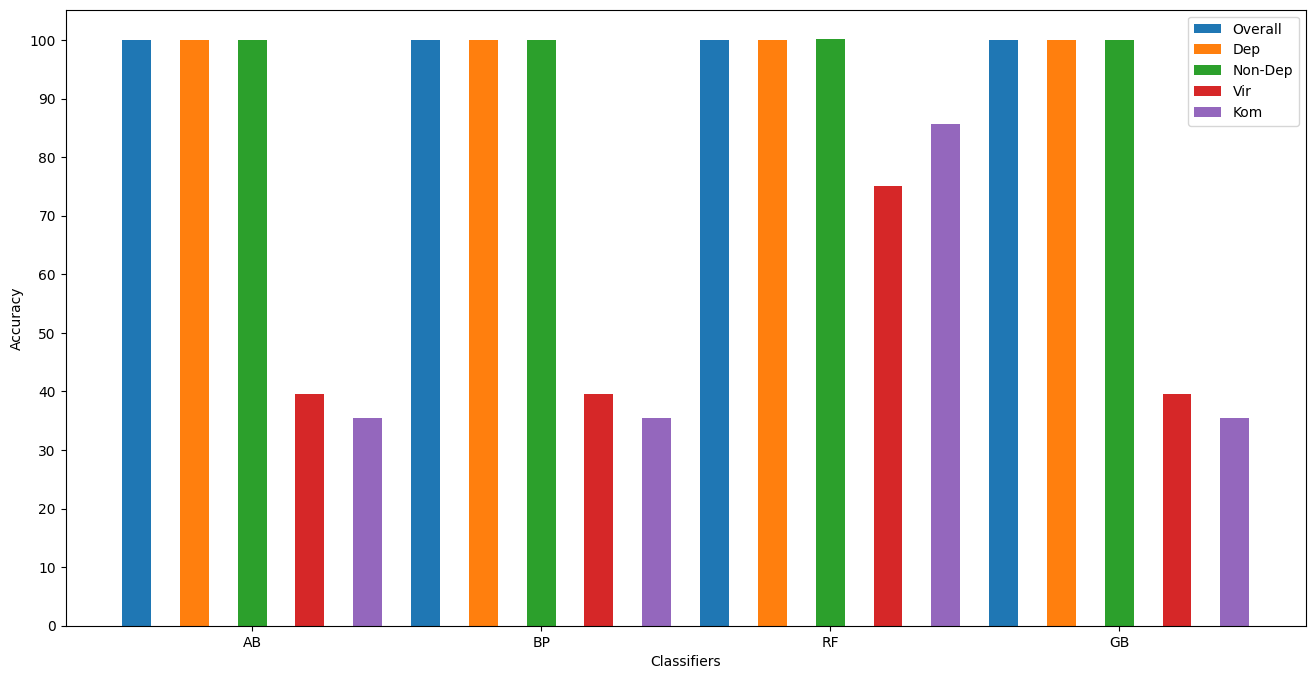

In [90]:
plt.figure(figsize=(16,8))
plt.bar(bar1, Ens_df['Acc'], label='Overall', align='edge', width=0.1)
plt.bar(bar2, Ens_df['Dep'], align='edge', width=0.1, label='Dep')
plt.bar(bar3, Ens_df['Non-Dep'], align='edge', width=0.1, label='Non-Dep')
plt.bar(bar4, Ens_df['Vir'], align='edge', width=0.1, label='Vir')
plt.bar(bar5, Ens_df['Kom'], align='edge', width=0.1, label='Kom')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks(bar1+0.45, x)
plt.yticks(np.arange(0, 101, 10))
plt.legend(loc='upper right')
plt.show()